## Evaluate Microsoft Phi 3 LLM for answer generation

https://huggingface.co/microsoft/Phi-3-mini-4k-instruct

In [1]:
# provide project root path
ProjectRoot = "/home/sangram/Tutorbot_capstone/git_hub/Tutorbot/"
DatasetRoot = ProjectRoot + "/Dataset/"

In [3]:
try:
    import bert_score
except ImportError:
    !pip install bert_score

try:
    from evaluate import load
except ImportError:
    !pip install evaluate

try:
    import rouge_score
except ImportError:
    !pip install rouge_score


  Using cached bert_score-0.3.13-py3-none-any.whl.metadata (15 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata 

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import pandas as pd
import json
import bert_score
import numpy as np
import re
from evaluate import load
from tqdm.notebook import tqdm

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# load context and question train set which was created by doc2query
train_df = pd.read_csv(DatasetRoot + 'q_a_trainset.csv')

In [6]:
# loading full article from json file
with open(DatasetRoot + 'raw_knowledge.json', 'r') as f:
    raw_text_json = json.load(f)

In [7]:
raw_df = pd.DataFrame(list(raw_text_json.items()), columns=['raw_para_id', 'raw_text'])
raw_df['raw_para_id'] = raw_df['raw_para_id'].astype('int64')

In [8]:
# create dataframe of raw, summarized paragraphs and question
train_df = train_df.merge(raw_df, left_on='raw_para_id', right_on='raw_para_id', how='left')

In [9]:
# dataframe holding metrics for different Prompt styles
Prompt_style_df = pd.DataFrame(columns=['Prompt_style', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1', 'METEOR', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum'])

### Helper Methods

In [10]:
# LLM inference wrapper
def AskLLM(context, question, prompt_style):

    if prompt_style == "zero_shot":
        prompt = generate_prompt_zeroshot(context, question)
    elif prompt_style == "few_shot":
        prompt = generate_prompt_fewshot(context, question)
    elif prompt_style == "chain_of_thought":
        prompt = generate_prompt_cot(context, question)
    else:
        raise Exception("prompt style not implemented!!")

    messages = [
    {"role": "user", "content": prompt}]

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "do_sample": False,
    }

    output = phi3_pipeline(messages, **generation_args)
    text = output[0]['generated_text']

    # Regular expression to extract the Final Answer
    if prompt_style == "zero_shot":
        answer_pattern = r"(.*)"
    else:
        answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)"

    # Extract answer from LLM response
    match = re.search(answer_pattern, text, re.DOTALL)
    final_answer = "I don't know"
    if match:
        final_answer = match.group(1).strip()
    else:
        print("Final Answer not found !!!")
        print("Final Answer:", text)

    return final_answer

In [11]:
def calculate_metrics(metrics_df, prompt_style, candidate_answers, true_answers):
    # Calculate BERTScore
    # bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='roberta-large', nthreads=4)
    bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='bert-base-uncased', nthreads=4)

    # Fetch precision, recall, F1 score from BERT score (https://lightning.ai/docs/torchmetrics/stable/text/bert_score.html)
    BERTScore_Precision = np.mean(np.array(bert_metrics[0]))
    BERTScore_Recall = np.mean(np.array(bert_metrics[1]))
    BERTScore_F1 =  np.mean(np.array(bert_metrics[2]))
    print(f"BERTScore Precision: {BERTScore_Precision}")
    print(f"BERTScore Recall: {BERTScore_Recall}")
    print(f"BERTScore F1 Score: {BERTScore_F1}")

    # calculate meteor via https://huggingface.co/spaces/evaluate-metric/meteor
    meteor = load('meteor')
    Meteor_score = meteor.compute(predictions=candidate_answers, references=true_answers)
    Meteor_score = Meteor_score['meteor']
    print(f"METEOR Score: {Meteor_score}")

    # calculate rouge via https://huggingface.co/spaces/evaluate-metric/rouge
    rouge = load("rouge")
    rouge_score = rouge.compute(predictions=candidate_answers, references=true_answers)
    print(f"ROUGE Score: {rouge_score}")
    Rouge1  = rouge_score['rouge1']
    Rouge2  = rouge_score['rouge2']
    RougeL  = rouge_score['rougeL']
    RougeLsum = rouge_score['rougeLsum']

    # record results
    new_row = pd.DataFrame({
        'Prompt_style': [prompt_style],
        'BERTScore_Precision': [BERTScore_Precision],
        'BERTScore_Recall': [BERTScore_Recall],
        'BERTScore_F1': [BERTScore_F1],
        'METEOR': [Meteor_score],
        'Rouge1': [Rouge1],
        'Rouge2': [Rouge2],
        'RougeL': [RougeL],
        'RougeLsum': [RougeLsum]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

### Evaluation

In [12]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is available!!")
else:
    raise RuntimeError("CUDA is not available!! LLM cannot run, rerun with GPU")

CUDA is available!!


In [13]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

phi3_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


#### Prompt Engineering
##### Experiment with different prompt templates
NOTE: Following prompts are created with the aid of ChatGPT

In [14]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)



In [15]:
def generate_prompt_cot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate a detailed and logical answer based on the provided context. Think through the problem step by step before giving the final answer. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.
3. **Step-by-Step Reasoning:** Break down the thought process into logical steps to arrive at the answer.
4. **Final Answer:** The concise answer derived from the step-by-step reasoning.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Step-by-Step Reasoning:**
1. The rainforests absorb carbon dioxide from the atmosphere.
2. They release oxygen, which is essential for life on Earth.
3. The process of absorbing carbon dioxide helps to reduce the overall levels of this greenhouse gas in the atmosphere.
4. Lower levels of carbon dioxide contribute to the regulation of the Earth's climate.
5. Therefore, the rainforests play a crucial role in maintaining the balance of gases in the atmosphere.

**Final Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Step-by-Step Reasoning:**
1.

2.

3.

4.

5.

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)


In [16]:
def generate_prompt_zeroshot(context, question):
    prompt = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt.format(context=context, question=question)

#### Calculate Different metric scores

In [17]:
prompt_styles = ["zero_shot", "few_shot", "chain_of_thought"]

for prompt_style in prompt_styles:
    candidate_answers = []
    true_answers = []

    for _, eval_data in tqdm(train_df.iterrows()):
        context = eval_data.raw_text
        question = eval_data.question

        true_answers.append(eval_data.Final_answer)
        candidate_answers.append(AskLLM(context, question, prompt_style))

    Prompt_style_df = calculate_metrics(metrics_df = Prompt_style_df, prompt_style = prompt_style, candidate_answers = candidate_answers, true_answers = true_answers)




0it [00:00, ?it/s]

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore Precision: 0.532444179058075
BERTScore Recall: 0.7401052117347717
BERTScore F1 Score: 0.6110572218894958


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


METEOR Score: 0.43237037102475223


ROUGE Score: {'rouge1': 0.3286752228613786, 'rouge2': 0.20289459403614357, 'rougeL': 0.28130224524028113, 'rougeLsum': 0.2825272130892177}


<ipython-input-11-d17cbec22491>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


0it [00:00, ?it/s]

Final Answer not found !!!
Final Answer:  I don't know.
Final Answer not found !!!
Final Answer:  **Answer:**
Data science is a field that unifies statistics, data analysis, informatics, and their related methods to understand and analyze actual phenomena with data. It incorporates techniques and theories from mathematics, statistics, computer science, information science, and domain knowledge. Data science is considered a "fourth paradigm" of science, which includes empirical, theoretical, computational, and data-driven approaches.
Final Answer not found !!!
Final Answer:  I'm sorry, but there seems to be a mistake in the question. The term "dcologist" does not appear to be relevant to the context provided. Could you please clarify or provide the correct term?
Final Answer not found !!!
Final Answer:  For your data science job, you need to prepare data for analysis, formulate data science problems, analyze data, develop data-driven solutions, and present findings to inform high-level 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.45648515967932246
ROUGE Score: {'rouge1': 0.39255226729820236, 'rouge2': 0.28314828808406045, 'rougeL': 0.3534187068990658, 'rougeLsum': 0.3545041450490174}


0it [00:00, ?it/s]

BERTScore Precision: 0.5743143558502197
BERTScore Recall: 0.7194778323173523
BERTScore F1 Score: 0.629416286945343


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.43163485360899534
ROUGE Score: {'rouge1': 0.37547988557080747, 'rouge2': 0.2445116539143128, 'rougeL': 0.32786305733208465, 'rougeLsum': 0.32776263516703436}


### Visualization of different Prompt style performance

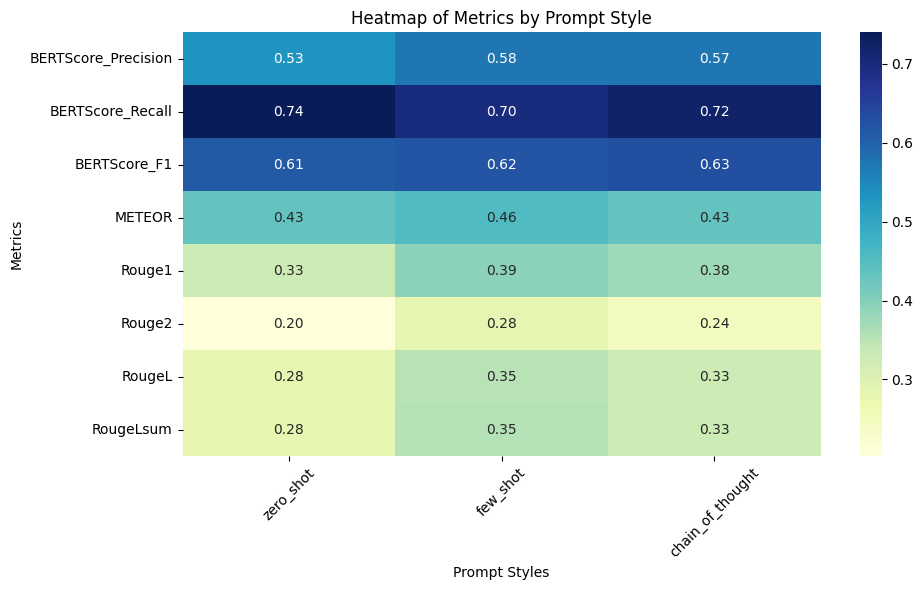

In [18]:

# pivot to have Prompt_style on x-axis
heatmap_data = Prompt_style_df.set_index('Prompt_style').T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Metrics by Prompt Style')
plt.xlabel('Prompt Styles')
plt.ylabel('Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
